In [1]:
import os
from control.matlab import ss, lsim, linspace, c2d
from PID import PID
from sim3 import vt,dc,ap,qd
import matplotlib.pyplot as plt
import numpy as np
import time
import statistics

In [2]:
# you can use vt, dc and ap
a = vt()
print(a.sysd)
# a.ref = [0] * 251 + [2] * 250
# a.thres=6

A = [[0.84648172]]

B = [[0.09211097]]

C = [[1.]]

D = [[0.]]

dt = 0.02



In [3]:
#only for vt
control_inputs = []
measures=[]
x_just_before = 0
xout=1
pid = PID(P=a.p, I=a.i, D=a.d, current_time=0)
pid.setWindup(100)
pid.setSampleTime(a.Ts)
for i in range(0, a.slot+1):
    a.y_real_arr.append(a.yreal)
    # sensor attack here
    a.score.append(a.s)
    pid.SetPoint = a.ref[i]
    pid.update(feedback_value=a.ymeasure, current_time=i * a.Ts)
    a.cin = pid.output
#     print(a.ymeasure,i,a.cin,xout)
    if a.cin>5:
        a.cin=5
    elif a.cin<-5:
        a.cin = -5
    else:
        a.cin=a.cin
    control_inputs.append(a.cin)
    if i>a.place:
        if (a.score[-1]==a.thres):
            a.att=a.drift
        else:
            a.att = a.thres+a.drift-a.score[-1]
    
    yout, T, xout = lsim(a.sysc, a.cin, [0, a.Ts], a.ymeasure)
    ymax, T, xout1 = lsim(a.sysc, a.maxc, [0, a.Ts], a.ymeasure)
    yout2, T, xout2 = lsim(a.sysc, a.cin, [0, a.Ts], a.yreal)
    a.yreal=yout2[-1]
    ypred = yout[-1]
    a.ymeasure = yout[-1]-a.att
#     if i>a.place-1:
#         a.ymeasure = min(ymax[-1],yout[-1]-a.att)
#         print(a.ymeasure,a.cin)
    a.s = a.score[-1]+abs(ypred-a.ymeasure)-a.drift
    if(a.s<0):
        a.s=0
    if(i==a.place+1):
        x_just_before = xout
    measures.append(a.ymeasure)

# print(control_inputs[a.place+2:])
# print(a.score[a.place+2:])
# print(x_just_before)


In [4]:
# ---------------------------------------
max_k = 450
attack_inputs = control_inputs[a.place+2:]
print('attack_inputs=', attack_inputs)
for j in range(0, len(attack_inputs)-10):
    temp = attack_inputs[j:j+10]
    if 5 in temp or 5 in temp:
        continue
    vari = statistics.variance(temp)
    print(vari, end= ' ')
    if(vari < 1e-6):
        max_k = j
        break
print('max_k', max_k)

attack_inputs = np.array([control_inputs[a.place+2:]])
x_just_before = x_just_before[-1]
print(x_just_before, len(x_just_before.shape))
if len(x_just_before.shape) == 0:
    x_a = np.array([[x_just_before]])
else:
    x_a = np.array([[item] for item in x_just_before])
# def get_safetime(self, x_a, safe_set_lo, safe_set_up, control_list: np.array, max_k)
safe_set_lo = a.safeset['lo']
safe_set_up = a.safeset['up']
k = a.est.get_safetime(x_a, safe_set_lo, safe_set_up, attack_inputs, max_k)
print(k)

# ---------------------------------------
        


attack_inputs= [1.6666725064903742, 5, 5, 5, 5, 5, 5, 4.862332517356338, 4.786998639049702, 4.786998639049702, 4.578899029148652, 4.578899029148652, 4.370839361894953, 4.370839361894953, 4.172713289453148, 4.172713289453148, 3.990295496189999, 3.990295496189999, 3.8264845703077857, 3.8264845703077857, 3.6822248333060177, 3.6822248333060177, 3.557181534251689, 3.557181534251689, 3.4502281416178286, 3.4502281416178286, 3.35979177031078, 3.35979177031078, 3.284092572206534, 3.284092572206534, 3.221304765195524, 3.221304765195524, 3.169660509029703, 3.1468089074409002, 3.1468089074409002, 3.1089993436336165, 3.1089993436336165, 3.0784769077186747, 3.0784769077186747, 3.0540097873491137, 3.0540097873491137, 3.034531733762302, 3.034531733762302, 3.0191318277473984, 3.0191318277473984, 3.007040619730115, 3.007040619730115, 2.997614640193391, 2.997614640193391, 2.990320618636561, 2.9870832994790253, 2.9870832994790253, 2.9822337282919618, 2.9822337282919618, 2.978562147230217, 2.97856214723021

C:\Users\Mengyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


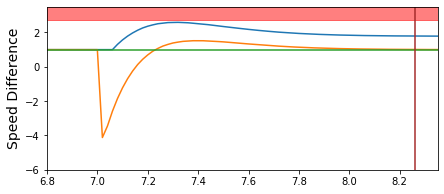

In [5]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.set_ylim(-6,3.5)
ax.set_xlim(6.8,8.35)
ax.plot(a.t_arr, a.y_real_arr,label='real')
ax.plot(a.t_arr, measures,label='measure')
ax.plot(a.t_arr, a.ref,label='ref')
ax.axhspan(2.7, 3.5, color='r', alpha=0.5)
ax.axvline((a.place+2+k)*a.Ts, color='brown',label='stable')
ax.set_ylabel('Speed Difference', fontsize=14)
# ax.legend()
fig.show()
# fig.savefig('vt_unsafe_ref.pdf',bbox_inches='tight')
fig.savefig('vt_safe.pdf',bbox_inches='tight')
# fig.savefig('vt_unsafe_thres.pdf',bbox_inches='tight')

In [126]:
# you can use vt, dc and ap\
import math
a = dc()
print(a.sysd)
# a.ref = [math.pi / 2+1] * 71 + [-math.pi / 2] * 50
a.thres = 5
a.drift = 1

A = [[ 1.          0.08645683  0.00979615]
 [ 0.          0.13523578  0.06686454]
 [ 0.         -0.00133729  0.67015208]]

B = [[0.00155661]
 [0.01959229]
 [0.329652  ]]

C = [[1. 0. 0.]]

D = [[0.]]

dt = 0.2



In [127]:
#for ap and dc
control_inputs = []
measures = []
x_just_before = 0
pid = PID(P=a.p, I=a.i, D=a.d, current_time=0)
pid.setWindup(100)
pid.setSampleTime(a.Ts)
x_compromise = 0

for i in range(0, a.slot+1):
    
    a.y_real_arr.append(a.yreal)
    # sensor attack here
    a.score.append(a.s)
    pid.SetPoint = a.ref[i]
#     print(a.ymeasure,i * a.Ts)
    pid.update(feedback_value=a.ymeasure, current_time=i * a.Ts)
    a.cin = pid.output

    if a.cin>20:
        a.cin=20
    elif a.cin<-20:
        a.cin = -20
    else:
        a.cin=a.cin
    control_inputs.append(a.cin)
    if i>a.place:
        if (a.score[-1]>a.thres):
            a.att=a.drift

        else:
            a.att = a.thres+a.drift-a.score[-1]
    if i == a.place+1:
        x_just_before = xout2
            
    yout, T, xout = lsim(a.sysc, a.cin, [0, a.Ts], a.xmeasure)
    ymax,T,xout1 = lsim(a.sysc, a.maxc, [0, a.Ts], a.xmeasure)
    yout2, T, xout2 = lsim(a.sysc, a.cin, [0, a.Ts], a.xreal)
    a.yreal=yout2[-1]
    ypred = yout[-1]
    a.xmeasure = xout[-1, :].T
    a.xreal = xout2[-1, :].T
    a.ymeasure = yout[-1]-a.att
#     if i>a.place and a.score[-1]<a.thres :
# #         print(i,a.s)
#         if(ymax[-1]>a.ymeasure-a.att):
        
#             a.ymeasure = max(ymax[-1],yout[-1]-a.att)
#             a.xreal = xout1[-1, :].T
#             a.xmeasure = xout1[-1, :].T
#             x_compromise = 1
            
# #             print(a.ymeasure, ypred)
#             print(i, ypred, a.ymeasure,a.s)
    a.s = a.score[-1]+abs(ypred-a.ymeasure)-a.drift
#     print(a.s)
    if(a.s<0):
        a.s=0
    measures.append(a.ymeasure)
#waht you need
# print(control_inputs)
# print(x_just_before)

In [128]:
a.score

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0]

In [129]:
control_inputs[a.place:]

[0.08494881469633461,
 0.04507953498659299,
 20,
 -20,
 8.270513756315694,
 8.270513756315694,
 9.28596041447955,
 7.082521048889239,
 5.124916345079232,
 3.5615103518259983,
 3.5615103518259983,
 1.4773357105550837,
 0.9660186506924533,
 0.6330513147433878,
 0.45097421386334635,
 0.45097421386334635,
 0.1322227846632429,
 0.19459354784102834,
 0.1663752631538412,
 0.13720402417704164,
 0.13720402417704164,
 0.056614440201381455,
 0.056614440201381455,
 0.03239534408441537,
 0.04093968997219741,
 0.04093968997219741,
 0.020542093725422636,
 0.020542093725422636,
 0.011638510448315015,
 0.011638510448315015,
 0.007341428940068992,
 0.007989624145639489,
 0.007989624145639489,
 0.003920509314256035,
 0.003920509314256035,
 0.0020007934839209943,
 0.0020567653082026677,
 0.0020567653082026677,
 0.000908910064922888,
 0.000908910064922888,
 0.000490927866982232,
 0.000571328572166247,
 0.000571328572166247,
 0.00027313793969963094,
 0.00027313793969963094,
 0.00015270660149679759,
 0.00016

In [130]:
# ---------------------------------------
max_k = 450
attack_inputs = control_inputs[a.place+2:]
print('attack_inputs=', attack_inputs)
for j in range(0, len(attack_inputs)-10):
    temp = attack_inputs[j:j+10]
    if 20 in temp or -20 in temp:
        continue
    vari = statistics.variance(temp)
    print(vari, end= ' ')
    if(vari < 1e-6):
        max_k = j
        print('this is temp')
        print(temp)
        break
print('max_k', max_k)

attack_inputs = np.array([control_inputs[a.place+2:]])
x_just_before = x_just_before[-1]
print(x_just_before, len(x_just_before.shape))
if len(x_just_before.shape) == 0:
    x_a = np.array([[x_just_before]])
else:
    x_a = np.array([[item] for item in x_just_before])
print('x_a=', x_a)
# def get_safetime(self, x_a, safe_set_lo, safe_set_up, control_list: np.array, max_k)
safe_set_lo = a.safeset['lo']
safe_set_up = a.safeset['up']
k = a.est.get_safetime(x_a, safe_set_lo, safe_set_up, attack_inputs, max_k)
print(k)

# ---------------------------------------
        


attack_inputs= [20, -20, 8.270513756315694, 8.270513756315694, 9.28596041447955, 7.082521048889239, 5.124916345079232, 3.5615103518259983, 3.5615103518259983, 1.4773357105550837, 0.9660186506924533, 0.6330513147433878, 0.45097421386334635, 0.45097421386334635, 0.1322227846632429, 0.19459354784102834, 0.1663752631538412, 0.13720402417704164, 0.13720402417704164, 0.056614440201381455, 0.056614440201381455, 0.03239534408441537, 0.04093968997219741, 0.04093968997219741, 0.020542093725422636, 0.020542093725422636, 0.011638510448315015, 0.011638510448315015, 0.007341428940068992, 0.007989624145639489, 0.007989624145639489, 0.003920509314256035, 0.003920509314256035, 0.0020007934839209943, 0.0020567653082026677, 0.0020567653082026677, 0.000908910064922888, 0.000908910064922888, 0.000490927866982232, 0.000571328572166247, 0.000571328572166247, 0.00027313793969963094, 0.00027313793969963094, 0.00015270660149679759, 0.00016756151087760242, 0.00016756151087760242, 7.913647387081135e-05, 7.9136473

C:\Users\Mengyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


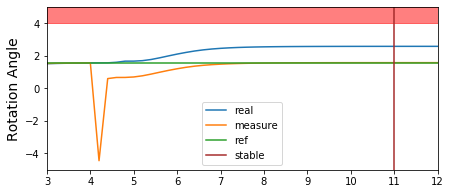

In [131]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.set_ylim(-5,5)
ax.set_xlim(3,12)
ax.plot(a.t_arr, a.y_real_arr,label='real')
ax.plot(a.t_arr, measures,label='measure')
ax.plot(a.t_arr, a.ref,label='ref')
ax.axhspan(4, 5, color='r', alpha=0.5)
ax.axvline((a.place+2+k)*a.Ts, color='brown',label='stable')
ax.set_ylabel('Rotation Angle', fontsize=14)
ax.legend()
fig.show()
# fig.savefig('dc_unsafe_ref.pdf',bbox_inches='tight')
fig.savefig('dc_safe_limit20.pdf',bbox_inches='tight')
# fig.savefig('vt_unsafe_thres.pdf',bbox_inches='tight')

In [92]:
len(a.ref)

121

In [ ]:
print(a.score)

In [96]:
a = qd()
print(a.sysc)
# a.ref = [2] * 601 + [4] * 600 + [2] * 300
a.thres = 80

A = [[ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -9.81  0.    0.    0.    0.    0.    0.    0.  ]
 [ 9.81  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.    0.    0.    0.  ]]

B = [[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [2.13675214]
 [0.        ]
 [0.        ]
 [0.        ]]

C = [[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]

D = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]



In [97]:
#for ap and dc
control_inputs = []
measures = []
x_just_before = 0
pid = PID(P=a.p, I=a.i, D=a.d, current_time=0)
pid.setWindup(100)
pid.setSampleTime(a.Ts)
for i in range(0, a.slot+1):
    a.y_real_arr.append(a.yreal)
    # sensor attack here
    a.score.append(a.s)
    pid.SetPoint = a.ref[i]
#     print(a.ymeasure,i * a.Ts)
    pid.update(feedback_value=a.ymeasure, current_time=i * a.Ts)
    a.cin = pid.output

#     if a.cin>50:
#         a.cin=50
#     elif a.cin<-50:
#         a.cin = -50
#     else:
#         a.cin=a.cin
    control_inputs.append(a.cin)
    if i>a.place:
        if (a.score[-1]==a.thres):
            a.att=a.drift
        else:
            a.att = a.thres+a.drift-a.score[-1]
            x_just_before = xout 
    yout, T, xout = lsim(a.sysc, a.cin, [0, a.Ts], a.xmeasure)
    yout2, T, xout2 = lsim(a.sysc, a.cin, [0, a.Ts], a.xreal)
    a.yreal=yout2[-1][-1]
    ypred = yout[-1][-1]
    a.xmeasure = xout[-1, :].T
    a.xreal = xout2[-1, :].T
    a.ymeasure = yout[-1][-1]-a.att
#     if i>a.place:
#         a.ymeasure = min(ymax[-1],yout[-1]-a.att)
    a.s = a.score[-1]+abs(ypred-a.ymeasure)-a.drift
    if(a.s<0):
        a.s=0
    measures.append(a.ymeasure)
#waht you need
# print(control_inputs)
# print(x_just_before)

In [98]:
# ---------------------------------------
max_k = 450
attack_inputs = control_inputs[a.place+2:]
print('attack_inputs=', attack_inputs)
for j in range(0, len(attack_inputs)-10):
    temp = attack_inputs[j:j+10]
    if 50 in temp or -50 in temp:
        continue
    vari = statistics.variance(temp)
    print(vari, end= ' ')
    if(vari < 1e-9):
        max_k = j
        print('this is temp')
        print(temp)
        break
print('max_k', max_k)

attack_inputs = np.array([control_inputs[a.place+2:]])
x_just_before = x_just_before[-1]
print(x_just_before, len(x_just_before.shape))
if len(x_just_before.shape) == 0:
    x_a = np.array([[x_just_before]])
else:
    x_a = np.array([[item] for item in x_just_before])
# def get_safetime(self, x_a, safe_set_lo, safe_set_up, control_list: np.array, max_k)
safe_set_lo = a.safeset['lo']
safe_set_up = a.safeset['up']
k = a.est.get_safetime(x_a, safe_set_lo, safe_set_up, attack_inputs, max_k)
print(k)

# ---------------------------------------
        


attack_inputs= [1222.9543125391674, 1222.9543125391674, -1231.609520820587, -1231.609520820587, -31.5960610817621, -31.5960610817621, 0.8012895331106646, 0.8012895331106646, 1.603627022940362, 1.603627022940362, 1.5542793619562425, 1.5542793619562425, 1.4850844564058443, 1.4850844564058443, 1.4184095544730337, 1.4184095544730337, 1.3547221699951257, 1.3061859255467358, 1.3061859255467358, 1.2653896064365013, 1.2653896064365013, 1.2090760473691489, 1.2090760473691489, 1.1548294995964576, 1.1548294995964576, 1.1030137399397315, 1.1030137399397315, 1.053531570518094, 1.053531570518094, 1.006278143669271, 1.006278143669271, 0.9611530125002576, 0.9611530125002576, 0.9180602492877953, 0.9180602492877953, 0.8769082503310894, 0.8769082503310894, 0.8376095412590264, 0.8376095412590264, 0.8000805908900543, 0.8000805908900543, 0.764241633475583, 0.7369042826423304, 0.7369042826423304, 0.7139710565797881, 0.7139710565797881, 0.6822808371298781, 0.6822808371298781, 0.6517525433096337, 0.65175254330

C:\Users\Mengyu\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


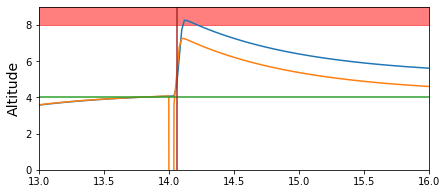

In [100]:
fig, ax = plt.subplots(figsize=(7, 3))
ax.set_ylim(0,9)
ax.set_xlim(13,16)
ax.plot(a.t_arr, a.y_real_arr,label='real')
ax.plot(a.t_arr, measures,label='measure')
ax.plot(a.t_arr, a.ref,label='ref')
ax.axhspan(8, 9, color='r', alpha=0.5)
ax.axvline((a.place+2+k)*a.Ts, color='brown',label='stable')
ax.set_ylabel('Altitude', fontsize=14)
# ax.legend()
fig.show()
fig.savefig('qd_unsafe_ref.pdf',bbox_inches='tight')
# fig.savefig('qd_safe.pdf',bbox_inches='tight')
# fig.savefig('vt_unsafe_thres.pdf',bbox_inches='tight')